In [36]:
# Install required packages
!pip install pandas numpy matplotlib seaborn scikit-learn

Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\program files (x86)\python\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# Use evaluation metrics are accuracy_score, precision, recall, F1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
# Remove the UndefinedMetricWarning warning
import warnings
from sklearn.exceptions import UndefinedMetricWarning, ConvergenceWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

DATA_FOLDER = 'data'

NAME = 'name'
GENRES = 'genres'
DESCRIPTION = 'description_raw'
DESCRIPTION_CLEANED = 'description_cleaned'
DESCRIPTION_LEMMATIZED = 'description_lemmatized'
DESCRIPTION_STEMMED = 'description_stemmed'
DESCRIPTION_NO_LEMMA_STEM = 'description_no_lemma_stem'

TEST_SIZE = 0.2
RANDOM_STATE = 42

In [38]:
# Load the data
df = pd.read_csv(os.path.join(DATA_FOLDER, 'steam_games_reduced_2.csv'))

In [39]:
# Split the data into features and target
X1_raw = df[DESCRIPTION]
X1_cleaned = df[DESCRIPTION_CLEANED]
X1_lemma = df[DESCRIPTION_LEMMATIZED]
X1_stem = df[DESCRIPTION_STEMMED]
X1_no_lemma_stem = df[DESCRIPTION_NO_LEMMA_STEM]
y = df[GENRES]

def split_data(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    # Print the shape of the training and testing sets
    print(f"Training set shape X: {X_train.shape}, y: {y_train.shape}")
    print(f"Testing set shape X: {X_test.shape}, y: {y_test.shape}")
    return X_train, X_test, y_train, y_test

# Split the data into training and testing sets
X1_raw_train, X1_raw_test, y_train, y_test = split_data(X1_raw, y)
X1_cleaned_train, X1_cleaned_test, _, _ = split_data(X1_cleaned, y)
X1_lemma_train, X1_lemma_test, _, _ = split_data(X1_lemma, y)
X1_stem_train, X1_stem_test, _, _ = split_data(X1_stem, y)
X1_no_lemma_stem_train, X1_no_lemma_stem_test, _, _ = split_data(X1_no_lemma_stem, y)

Training set shape X: (2391,), y: (2391,)
Testing set shape X: (598,), y: (598,)
Training set shape X: (2391,), y: (2391,)
Testing set shape X: (598,), y: (598,)
Training set shape X: (2391,), y: (2391,)
Testing set shape X: (598,), y: (598,)
Training set shape X: (2391,), y: (2391,)
Testing set shape X: (598,), y: (598,)
Training set shape X: (2391,), y: (2391,)
Testing set shape X: (598,), y: (598,)


In [40]:
def fit_and_transform_vectorizer(vectorizer, X_train, X_test):
    # Fit and transform the vectorizer on the training data
    X_train_vectorized = vectorizer.fit_transform(X_train)
    # Transform the testing data
    X_test_vectorized = vectorizer.transform(X_test)
    return (X_train_vectorized, X_test_vectorized)

# Define the tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1))
tfidf_vectorizer_bigram = TfidfVectorizer(ngram_range=(1,2))

tfidf_vectors = {
    'Raw': fit_and_transform_vectorizer(tfidf_vectorizer, X1_raw_train, X1_raw_test),
    'Cleaned': fit_and_transform_vectorizer(tfidf_vectorizer, X1_cleaned_train, X1_cleaned_test),
    'Lemmatized': fit_and_transform_vectorizer(tfidf_vectorizer, X1_lemma_train, X1_lemma_test),
    'Stemmed': fit_and_transform_vectorizer(tfidf_vectorizer, X1_stem_train, X1_stem_test),
    'No lemma no stem': fit_and_transform_vectorizer(tfidf_vectorizer, X1_no_lemma_stem_train, X1_no_lemma_stem_test),
    'Raw w/ bigrams': fit_and_transform_vectorizer(tfidf_vectorizer_bigram, X1_raw_train, X1_raw_test),
    'Cleaned w/ bigrams': fit_and_transform_vectorizer(tfidf_vectorizer_bigram, X1_cleaned_train, X1_cleaned_test),
    'Lemmatized w/ bigrams': fit_and_transform_vectorizer(tfidf_vectorizer_bigram, X1_lemma_train, X1_lemma_test),
    'Stemmed w/ bigrams': fit_and_transform_vectorizer(tfidf_vectorizer_bigram, X1_stem_train, X1_stem_test),
    'No lemma no stem w/ bigrams': fit_and_transform_vectorizer(tfidf_vectorizer_bigram, X1_no_lemma_stem_train, X1_no_lemma_stem_test)
}

In [41]:
def train_and_predict(model, vectorizer_name: str, X_train, y_train, X_test, y_test):
    # Train the model
    trained_model = model.fit(X_train, y_train)
    
    # Predict the output
    y_pred = trained_model.predict(X_test)
    
    print(f"{model.__class__.__name__} with {vectorizer_name} : Accuracy {accuracy_score(y_test, y_pred):.4f}")
    
    # Return the trained model, vectorizer name and the predicted values
    return (trained_model, vectorizer_name, y_pred)

def build_predict_dict(model, tfidf_vectors):
    # Define the results dictionary
    results = {}
    full_name = ""
        
    for vectorizer_name, (X_train, X_test) in tfidf_vectors.items():
        full_name = "TfIdf / "+vectorizer_name
        results[(model, full_name)] = train_and_predict(model, full_name, X_train, y_train, X_test, y_test)
        
    return results

In [55]:
def evaluate_model(y_test, y_pred):
    # Calculate the evaluation metrics
    accuracy_value = accuracy_score(y_test, y_pred)
    precision_value = precision_score(y_test, y_pred, average='macro')
    recall_value = recall_score(y_test, y_pred, average='macro')
    f1_score_value = f1_score(y_test, y_pred, average='macro')
    
    return {
        'accuracy': accuracy_value,
        'precision': precision_value,
        'recall': recall_value,
        'f1_score': f1_score_value,
    }

def print_evaluation_metrics(vectorizer_name, evaluation_metrics, add_header=False):
    if add_header:
        print("="*80)
        print(f"{'Vectorizer/Data form':<38} {'Accuracy':<9} {'Precision':<9} {'Recall':<9} {'F1 Score':<9}")
        print("="*80)
    print(f"{vectorizer_name:<38} "
    f"{evaluation_metrics['accuracy']:<9.4f} "
    f"{evaluation_metrics['precision']:<9.4f} "
    f"{evaluation_metrics['recall']:<9.4f} "
    f"{evaluation_metrics['f1_score']:<9.4f}")

# Evaluate the models
def evaluate_models(results, y_test):
    evaluation_results = {}
    
    # Print the model name
    print(f"Model : {list(results.keys())[0][0].__class__.__name__}")
    
    # Print the header
    print("="*80)
    print(f"{'Vectorizer/Data form':<38} {'Accuracy':<9} {'Precision':<9} {'Recall':<9} {'F1 Score':<9}")
    print("="*80)
    
    for (model, vectorizer_name), (trained_model, vectorizer_name, y_pred) in results.items():
        evaluation_metrics = evaluate_model(y_test, y_pred)
        evaluation_results[(model, vectorizer_name)] = evaluation_metrics
        
        # Print the evaluation results
        print_evaluation_metrics(vectorizer_name, evaluation_metrics)
    return evaluation_results

In [43]:
# Train a multinomial naive bayes classifier
multinomial_nb = MultinomialNB()
multinomial_nb_results = build_predict_dict(multinomial_nb, tfidf_vectors)

MultinomialNB with TfIdf / Raw : Accuracy 0.6823
MultinomialNB with TfIdf / Cleaned : Accuracy 0.6940
MultinomialNB with TfIdf / Lemmatized : Accuracy 0.6890
MultinomialNB with TfIdf / Stemmed : Accuracy 0.6890
MultinomialNB with TfIdf / No lemma no stem : Accuracy 0.6923
MultinomialNB with TfIdf / Raw w/ bigrams : Accuracy 0.6756
MultinomialNB with TfIdf / Cleaned w/ bigrams : Accuracy 0.6923
MultinomialNB with TfIdf / Lemmatized w/ bigrams : Accuracy 0.6923
MultinomialNB with TfIdf / Stemmed w/ bigrams : Accuracy 0.6756
MultinomialNB with TfIdf / No lemma no stem w/ bigrams : Accuracy 0.6890


In [44]:
# Train a logistic regression model
logistic_regression = LogisticRegression(max_iter=1000, n_jobs=-1)
logistic_regression_results = build_predict_dict(logistic_regression, tfidf_vectors)

LogisticRegression with TfIdf / Raw : Accuracy 0.6773
LogisticRegression with TfIdf / Cleaned : Accuracy 0.6906
LogisticRegression with TfIdf / Lemmatized : Accuracy 0.6856
LogisticRegression with TfIdf / Stemmed : Accuracy 0.6706
LogisticRegression with TfIdf / No lemma no stem : Accuracy 0.6990
LogisticRegression with TfIdf / Raw w/ bigrams : Accuracy 0.6773
LogisticRegression with TfIdf / Cleaned w/ bigrams : Accuracy 0.6923
LogisticRegression with TfIdf / Lemmatized w/ bigrams : Accuracy 0.6773
LogisticRegression with TfIdf / Stemmed w/ bigrams : Accuracy 0.6589
LogisticRegression with TfIdf / No lemma no stem w/ bigrams : Accuracy 0.6890


In [45]:
# Train a random forest classifier
random_forest = RandomForestClassifier(n_jobs=-1)
random_forest_results = build_predict_dict(random_forest, tfidf_vectors)

RandomForestClassifier with TfIdf / Raw : Accuracy 0.6321
RandomForestClassifier with TfIdf / Cleaned : Accuracy 0.6538
RandomForestClassifier with TfIdf / Lemmatized : Accuracy 0.6237
RandomForestClassifier with TfIdf / Stemmed : Accuracy 0.6288
RandomForestClassifier with TfIdf / No lemma no stem : Accuracy 0.6288
RandomForestClassifier with TfIdf / Raw w/ bigrams : Accuracy 0.6221
RandomForestClassifier with TfIdf / Cleaned w/ bigrams : Accuracy 0.6288
RandomForestClassifier with TfIdf / Lemmatized w/ bigrams : Accuracy 0.6555
RandomForestClassifier with TfIdf / Stemmed w/ bigrams : Accuracy 0.6037
RandomForestClassifier with TfIdf / No lemma no stem w/ bigrams : Accuracy 0.6405


In [46]:
# Train a support vector classifier
svc = SVC()
svc_results = build_predict_dict(svc, tfidf_vectors)

SVC with TfIdf / Raw : Accuracy 0.6890
SVC with TfIdf / Cleaned : Accuracy 0.6906
SVC with TfIdf / Lemmatized : Accuracy 0.6906
SVC with TfIdf / Stemmed : Accuracy 0.6957
SVC with TfIdf / No lemma no stem : Accuracy 0.6923
SVC with TfIdf / Raw w/ bigrams : Accuracy 0.6706
SVC with TfIdf / Cleaned w/ bigrams : Accuracy 0.6823
SVC with TfIdf / Lemmatized w/ bigrams : Accuracy 0.6722
SVC with TfIdf / Stemmed w/ bigrams : Accuracy 0.6622
SVC with TfIdf / No lemma no stem w/ bigrams : Accuracy 0.6839


In [48]:
# Evaluate multinomialNB
multinomial_nb_evaluation_results = evaluate_models(multinomial_nb_results, y_test)

Model : MultinomialNB
Vectorizer/Data form                   Accuracy  Precision Recall    F1 Score 
TfIdf / Raw                            0.6823    0.6803    0.6824    0.6734   
TfIdf / Cleaned                        0.6940    0.6905    0.6942    0.6852   
TfIdf / Lemmatized                     0.6890    0.6832    0.6891    0.6816   
TfIdf / Stemmed                        0.6890    0.6837    0.6892    0.6820   
TfIdf / No lemma no stem               0.6923    0.6900    0.6925    0.6853   
TfIdf / Raw w/ bigrams                 0.6756    0.6740    0.6756    0.6656   
TfIdf / Cleaned w/ bigrams             0.6923    0.6921    0.6924    0.6834   
TfIdf / Lemmatized w/ bigrams          0.6923    0.6895    0.6924    0.6847   
TfIdf / Stemmed w/ bigrams             0.6756    0.6696    0.6758    0.6681   
TfIdf / No lemma no stem w/ bigrams    0.6890    0.6849    0.6891    0.6810   


In [49]:
# Evaluate logistic regression
logistic_regression_evaluation_results = evaluate_models(logistic_regression_results, y_test)

Model : LogisticRegression
Vectorizer/Data form                   Accuracy  Precision Recall    F1 Score 
TfIdf / Raw                            0.6773    0.6801    0.6771    0.6772   
TfIdf / Cleaned                        0.6906    0.6940    0.6906    0.6901   
TfIdf / Lemmatized                     0.6856    0.6918    0.6856    0.6868   
TfIdf / Stemmed                        0.6706    0.6741    0.6707    0.6703   
TfIdf / No lemma no stem               0.6990    0.7025    0.6990    0.6989   
TfIdf / Raw w/ bigrams                 0.6773    0.6791    0.6772    0.6756   
TfIdf / Cleaned w/ bigrams             0.6923    0.6916    0.6924    0.6898   
TfIdf / Lemmatized w/ bigrams          0.6773    0.6763    0.6774    0.6745   
TfIdf / Stemmed w/ bigrams             0.6589    0.6591    0.6591    0.6568   
TfIdf / No lemma no stem w/ bigrams    0.6890    0.6865    0.6891    0.6856   


In [50]:
# Evaluate random forest
random_forest_evaluation_results = evaluate_models(random_forest_results, y_test)

Model : RandomForestClassifier
Vectorizer/Data form                   Accuracy  Precision Recall    F1 Score 
TfIdf / Raw                            0.6321    0.6333    0.6322    0.6256   
TfIdf / Cleaned                        0.6538    0.6584    0.6540    0.6485   
TfIdf / Lemmatized                     0.6237    0.6204    0.6239    0.6146   
TfIdf / Stemmed                        0.6288    0.6301    0.6288    0.6221   
TfIdf / No lemma no stem               0.6288    0.6344    0.6288    0.6237   
TfIdf / Raw w/ bigrams                 0.6221    0.6229    0.6221    0.6160   
TfIdf / Cleaned w/ bigrams             0.6288    0.6362    0.6289    0.6187   
TfIdf / Lemmatized w/ bigrams          0.6555    0.6702    0.6556    0.6487   
TfIdf / Stemmed w/ bigrams             0.6037    0.6073    0.6038    0.5930   
TfIdf / No lemma no stem w/ bigrams    0.6405    0.6450    0.6404    0.6308   


In [51]:
# Evaluate support vector classifier
svc_evaluation_results = evaluate_models(svc_results, y_test)

Model : SVC
Vectorizer/Data form                   Accuracy  Precision Recall    F1 Score 
TfIdf / Raw                            0.6890    0.7004    0.6888    0.6913   
TfIdf / Cleaned                        0.6906    0.7063    0.6905    0.6939   
TfIdf / Lemmatized                     0.6906    0.7122    0.6906    0.6953   
TfIdf / Stemmed                        0.6957    0.7098    0.6957    0.6984   
TfIdf / No lemma no stem               0.6923    0.7110    0.6922    0.6962   
TfIdf / Raw w/ bigrams                 0.6706    0.6795    0.6705    0.6731   
TfIdf / Cleaned w/ bigrams             0.6823    0.6879    0.6824    0.6833   
TfIdf / Lemmatized w/ bigrams          0.6722    0.6882    0.6724    0.6752   
TfIdf / Stemmed w/ bigrams             0.6622    0.6721    0.6624    0.6638   
TfIdf / No lemma no stem w/ bigrams    0.6839    0.6922    0.6840    0.6858   


In [61]:
def plot_confusion_matrix(model_name, y_test, y_pred, vectorizer_name):
    clf_report = classification_report(y_test, y_pred, output_dict=True)
    
    # Print the classification report
    print(f"Classification Report for {model_name} with {vectorizer_name}")
    print("="*80)
    print(classification_report(y_test, y_pred))
    
    # Print the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
    # Get the labels and remove the 3 last labels but keep the order
    labels = list(clf_report.keys())[:-3]

    plt.figure(figsize=(10, 10))
    # Increase the size of the values in the heatmap
    plt.rcParams['font.size'] = 13
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.yticks(rotation=0)
    plt.ylabel('Actual')
    plt.title(f"{model_name}'s {vectorizer_name} Normalized Confusion Matrix")
    plt.show()

In [53]:
# From all the evaluation results, extract the best model
def get_best_model(evaluation_and_results):
    best_model = None
    best_f1_score = 0
    for model_name, results in evaluation_and_results.items():
        evaluation_results, model_results = results
        
        for (model, vectorizer_name), evaluation_metrics in evaluation_results.items():
            if evaluation_metrics['f1_score'] > best_f1_score:
                best_f1_score = evaluation_metrics['f1_score']
                key = (model, vectorizer_name)
                best_model = [model_name, key, evaluation_results[key], model_results[key]]
    return best_model


Classification Report for Logistic Regression with TfIdf / No lemma no stem
              precision    recall  f1-score   support

      Action       0.68      0.59      0.63        85
   Adventure       0.64      0.74      0.69        85
         RPG       0.72      0.66      0.69        85
      Racing       0.84      0.87      0.86        86
  Simulation       0.56      0.64      0.59        86
      Sports       0.81      0.79      0.80        85
    Strategy       0.68      0.60      0.64        86

    accuracy                           0.70       598
   macro avg       0.70      0.70      0.70       598
weighted avg       0.70      0.70      0.70       598



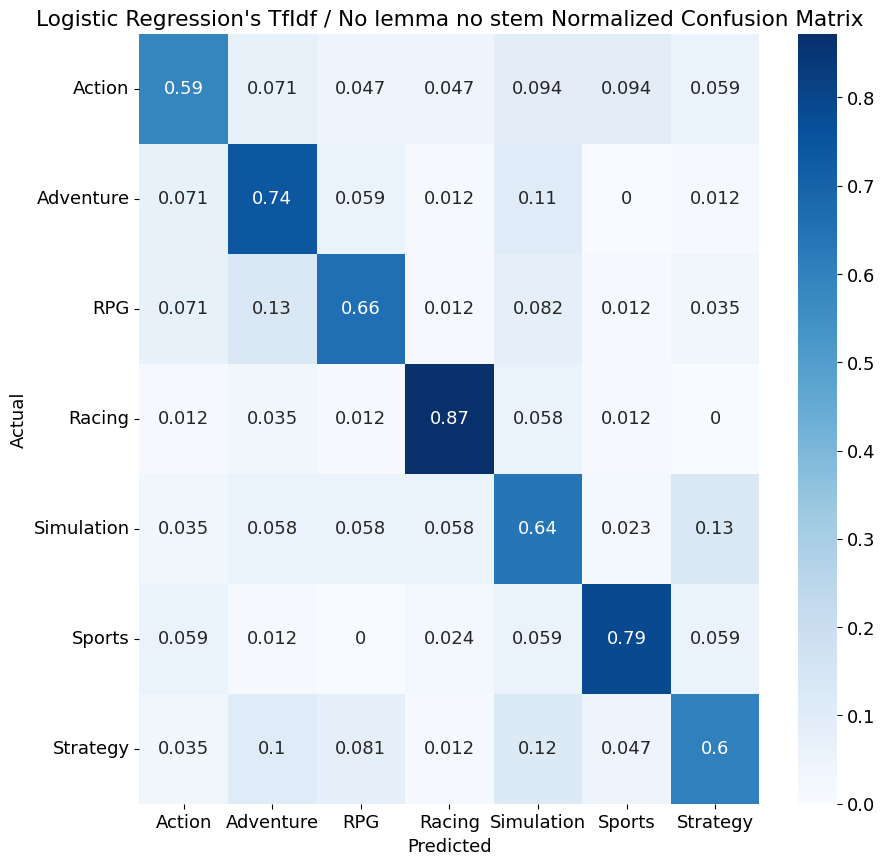

Best model: Logistic Regression with TfIdf / No lemma no stem
Vectorizer/Data form                   Accuracy  Precision Recall    F1 Score 
TfIdf / No lemma no stem               0.6990    0.7025    0.6990    0.6989   


In [62]:
# Fusion of all the evaluation results
all_evaluation_results = {
    'MultinomialNB': (multinomial_nb_evaluation_results, multinomial_nb_results),
    'Logistic Regression': (logistic_regression_evaluation_results, logistic_regression_results),
    'Random Forest': (random_forest_evaluation_results, random_forest_results),
    'Support Vector Classifier': (svc_evaluation_results, svc_results)
}

# Get the best model
best_results = get_best_model(all_evaluation_results)

print()

# Plot the best model's confusion matrix
plot_confusion_matrix(best_results[0], y_test, best_results[3][2], best_results[1][1])

# Print the best model's evaluation metrics
print(f"Best model: {best_results[0]} with {best_results[1][1]}")
print_evaluation_metrics(best_results[1][1], best_results[2], add_header=True)